# 프로젝트 : BERT pretrained model 제작

**노드를 보면서 문득 생각이 들었습니다.  
코드를 이해는 했는데 마냥 복사+붙여넣기를 하기엔 너무 재미없을 것 같아서 코드골프를 하는 컨셉을 잡으면 어떨까!?!?**

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
import time
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


## 1. Tokenizer

## 2. MLM

## 3. NSP

## 4. 데이터셋 생성

## 5. BERT 설계하기

## 6. BERT pre-train

- - -
### Tokenizer

In [2]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

#spm.SentencePieceTrainer.train(
#    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
#    " --model_type=bpe" +
#    " --max_sentence_length=999999" + # 문장 최대 길이
#    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
#    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
#    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
#    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
#    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

SentencePiece `ko8000` 모델의 학습은 처음 실행 때만 진행하고 이후는 불러오기만 했습니다.

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{prefix}.model")

True

In [4]:
len(vocab)

8007

SentencePiece 모델의 Vocab Size는 스페셜 토큰 7개를 포함한 8007개입니다.

In [5]:
vocab_list = [vocab.id_to_piece(id) for id in range(len(vocab)) if not vocab.is_unknown(id)]
# 단어를 마스킹하면서 무작위로 다른 토큰으로 변경하려고 할 때 꺼내올 토큰들 리스트

vocab_list[:10]

['[PAD]', '[BOS]', '[EOS]', '[SEP]', '[CLS]', '[MASK]', '▁1', '▁이', '으로', '에서']

단어장에서 스페셜 토큰이 아닌 유효한 토큰들만을 담은 리스트를 준비해줍니다.

앞에서 6개의 단어가 스페셜 토큰으로 이루어져있습니다.

In [6]:
vocab_list = vocab_list[6:]

vocab_list[:10]

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']

슬라이싱으로 제거할 경우 인덱스 6부터 슬라이싱하면 되겠습니다.

- - -
## MLM

In [7]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]

print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


다음과 같은 토큰이 있다고 칩시다.

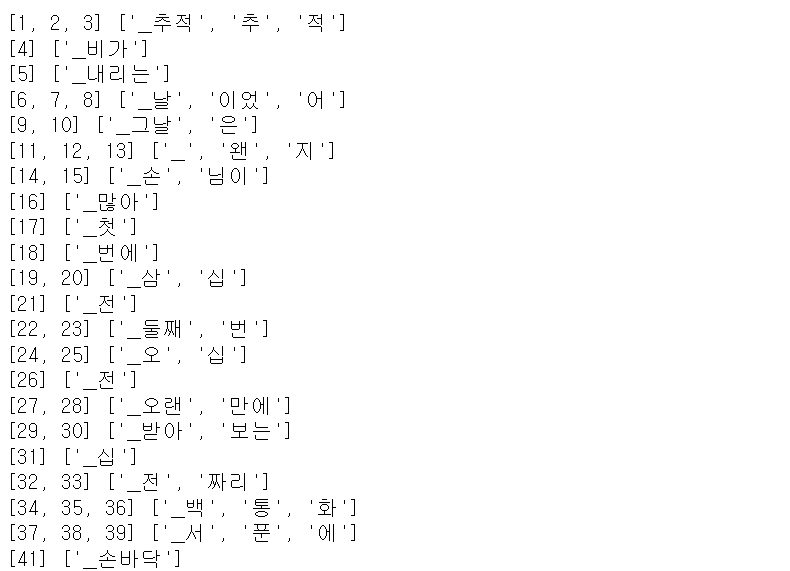

`▁`로 시작하는 토큰은 앞에 내용이 없거나 띄어쓰기가 있기 때문에 단어의 시작을 알리는 토큰입니다.

해당 토큰을 기준으로 이어지는 한 단어의 `[단어의 토큰들]`을 묶어주는 것이 첫 번째 목표입니다.

`▁`로 시작하는 토큰인지는 `token.startswith(u"\u2581")`를 통해 확인할 수 있습니다.

In [8]:
startwordtoken = [i for i, token in enumerate(tokens_org) if token.startswith(u"\u2581")] + [len(tokens_org)]
cand_idx = [[k for k in range(i, j) if tokens_org[k] != "[SEP]"] for i, j in zip(startwordtoken[:-1], startwordtoken[1:])]
# startwordtoken : 시작을 알리는 토큰들의 인덱스들 리스트
# cand_idx : 공백을 기준으로 한 하나의 단어 토큰들 묶음

for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['▁추', '적', '추', '적']
[5, 6] ['▁비', '가']
[7, 8] ['▁내', '리는']
[9, 10, 11] ['▁날', '이었', '어']
[12, 13, 14] ['▁그', '날', '은']
[15, 16, 17] ['▁', '왠', '지']
[18, 19, 20] ['▁손', '님', '이']
[21, 22] ['▁많', '아']
[23] ['▁첫']
[24, 25] ['▁번', '에']
[26, 27] ['▁삼', '십']
[28] ['▁전']
[29, 30, 31] ['▁둘', '째', '번']
[32, 33] ['▁오', '십']
[34] ['▁전']
[35, 36, 37] ['▁오', '랜', '만에']
[38, 39, 40] ['▁받아', '보', '는']
[41] ['▁십']
[42, 43, 44] ['▁전', '짜', '리']
[45, 46, 47] ['▁백', '통', '화']
[48, 49, 50] ['▁서', '푼', '에']
[52, 53, 54] ['▁손', '바', '닥']
[55, 56] ['▁위', '엔']
[57, 58, 59] ['▁기', '쁨', '의']
[60, 61] ['▁눈', '물이']
[62, 63] ['▁흘', '러']
[64, 65, 66] ['▁컬', '컬', '한']
[67, 68] ['▁목', '에']
[69, 70] ['▁모', '주']
[71, 72, 73] ['▁한', '잔', '을']
[74, 75] ['▁적', '셔']
[76] ['▁몇']
[77] ['▁달']
[78] ['▁포']
[79, 80] ['▁전', '부터']
[81, 82, 83, 84] ['▁콜', '록', '거', '리는']
[85] ['▁아내']
[86, 87] ['▁생각', '에']
[88, 89, 90] ['▁그', '토', '록']
[91, 92] ['▁먹', '고']
[93, 94, 95] ['▁싶', '다', '던']


두 줄의 코드로 원하는 결과는 나온 것 같습니다.

그렇다면 예제의 코드와 동일한 결과를 출력할 지 확인해보겠습니다.

In [9]:
# 띄어쓰기 단위로 mask하기 위해서 index 분할
cand_idx_other = []  # word 단위의 index array

for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
        cand_idx_other[-1].append(i)
    else:
        cand_idx_other.append([i])
        
    # _로 시작하는 토큰이면 리스트의 새로운 인덱스에 append, 아니면 마지막 인덱스에 토큰 추가

# 결과확인
print(cand_idx_other == cand_idx)

True


결과는 일치하네요.

아직 궁금한 점은 한 가지가 더 남아있습니다.

이렇게 코드골프를 하면 실행속도가 더 빨라지지 않을까? 하는 호기심이요.

In [10]:
starttime = time.time()

cand_idx_other = []  # word 단위의 index array

for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
        cand_idx_other[-1].append(i)
    else:
        cand_idx_other.append([i])

print(time.time() - starttime)

0.00017595291137695312


예제 코드의 실행 속도입니다.

In [11]:
starttime = time.time()

startwordtoken = [i for i, token in enumerate(tokens_org) if token.startswith(u"\u2581")] + [len(tokens_org)]
cand_idx = [[k for k in range(i, j) if tokens_org[k] != "[SEP]"] for i, j in zip(startwordtoken[:-1], startwordtoken[1:])]

print(time.time() - starttime)

0.0001811981201171875


두 줄로 코드골프를 한 코드의 실행속도입니다.

코드는 짧아졌지만 실행 속도는 더 느려졌습니다. 이럴수가..

리스트를 두 개 생성하는 게 영향이 큰 듯 해보입니다.

In [12]:
starttime = time.time()

for _ in range(2 ** 15):
    cand_idx_other = []  # word 단위의 index array
    
    for (i, token) in enumerate(tokens_org):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx_other[-1].append(i)
        else:
            cand_idx_other.append([i])

print(time.time() - starttime)

1.088165283203125


만약 반복문으로 엄청 많은 실행을 거치면 결과는 어떨까요?

예제의 함수는 약 1.08초가 나왔습니다.

In [13]:
starttime = time.time()

for _ in range(2 ** 15):
    startwordtoken = [i for i, token in enumerate(tokens_org) if token.startswith(u"\u2581")] + [len(tokens_org)]
    cand_idx = [[k for k in range(i, j) if tokens_org[k] != "[SEP]"] for i, j in zip(startwordtoken[:-1], startwordtoken[1:])]

print(time.time() - starttime)

0.9586496353149414


코드골프한 코드는 반복 실행시 약 0.95초로 더 빨라진 결과를 볼 수 있습니다.

또 예상치 못한 결과가 나왔군요.

모델 내에서 병렬로 처리될 코드는 아닌 것 같지만 그래도 일단 써보도록 하겠습니다.

In [14]:
# random mask를 위해서 index 순서를 섞음
random.shuffle(cand_idx)
cand_idx

[[24, 25],
 [57, 58, 59],
 [32, 33],
 [64, 65, 66],
 [41],
 [79, 80],
 [52, 53, 54],
 [67, 68],
 [29, 30, 31],
 [91, 92],
 [23],
 [26, 27],
 [76],
 [42, 43, 44],
 [78],
 [60, 61],
 [38, 39, 40],
 [93, 94, 95],
 [9, 10, 11],
 [81, 82, 83, 84],
 [85],
 [12, 13, 14],
 [34],
 [71, 72, 73],
 [77],
 [45, 46, 47],
 [48, 49, 50],
 [28],
 [74, 75],
 [62, 63],
 [88, 89, 90],
 [5, 6],
 [35, 36, 37],
 [55, 56],
 [18, 19, 20],
 [86, 87],
 [7, 8],
 [15, 16, 17],
 [1, 2, 3, 4],
 [21, 22],
 [69, 70]]

다음 스텝을 실험하기 위해 토큰 리스트의 인덱스를 섞어줍니다.

In [15]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)
mask_cnt = int((len(tokens_org) - 3) * 0.15)

mask_lms = []  # mask 된 값

for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    # 마스크 카운트를 넘으면 종료
    
    dice = random.random()  # 0과 1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token
        
    # 토큰했는지 카운트는 토큰 단위로 세지만 마스킹은 공백(_) 단위로 마스킹

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '프', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', '[MASK]', '▁목', '에'

15% 만큼을 무작위로 선택해 마스킹하는 함수입니다.

이번에도 위와 같은 결과가 나오도록 코드골프를 해보겠습니다.

In [16]:
mask_lms = {}

i = 0
while len(mask_lms) < mask_cnt: # while 조건문을 이용해 break, continue을 아낌
    dice = random.random()
    for index in cand_idx[i]:
        mask_lms[index] = tokens[index]
        if dice < 0.8:
            tokens[index] = "[MASK]"
        elif dice < 0.9:
            tokens[index] = random.choice(vocab_list)
        # else: 위 두 조건에 해당하지 않을 확률이 10%므로 아무것도 하지 않으면 10% 확률로 원본 그대로 유지
    i += 1

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '[MASK]', '[MASK]', '[MASK]', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', 

17줄의 코드에서 11줄의 코드로 줄였습니다.

정확히 일치하는 지는 알기 힘들지만... 맞을 거라고 믿습니다.

In [17]:
starttime = time.time()

mask_lms = []  # mask 된 값

for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    # 마스크 카운트를 넘으면 종료
    
    dice = random.random()  # 0과 1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token
        
    # 토큰했는지 카운트는 토큰 단위로 세지만 마스킹은 공백(_) 단위로 마스킹

print(time.time() - starttime)

0.00015306472778320312


예제의 코드 실행속도입니다.

In [18]:
starttime = time.time()

mask_lms = {}

i = 0
while len(mask_lms) < mask_cnt:
    dice = random.random()
    for index in cand_idx[i]:
        mask_lms[index] = tokens[index]
        if dice < 0.8:
            tokens[index] = "[MASK]"
        elif dice < 0.9:
            tokens[index] = random.choice(vocab_list)
        # else: 위 두 조건에 해당하지 않을 확률이 10%므로 아무것도 하지 않으면 10% 확률로 원본 그대로 유지
    i += 1

print(time.time() - starttime)

0.00013327598571777344


코드골프한 코드의 실행속도입니다.

오.. 상당히 흡족스러운 결과입니다.

In [19]:
starttime = time.time()

for _ in range(2 ** 15):
    mask_lms = []  # mask 된 값

    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
              break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
              continue
        # 마스크 카운트를 넘으면 종료

        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

        # 토큰했는지 카운트는 토큰 단위로 세지만 마스킹은 공백(_) 단위로 마스킹

print(time.time() - starttime)

0.28290748596191406


반복문으로 실행했을 때 예제의 코드는 약 0.28초가 나왔습니다.

In [20]:
starttime = time.time()

for _ in range(2 ** 15):
    mask_lms = {}

    i = 0
    while len(mask_lms) < mask_cnt:
        dice = random.random()
        for index in cand_idx[i]:
            mask_lms[index] = tokens[index]
            if dice < 0.8:
                tokens[index] = "[MASK]"
            elif dice < 0.9:
                tokens[index] = random.choice(vocab_list)
            # else: 위 두 조건에 해당하지 않을 확률이 10%므로 아무것도 하지 않으면 10% 확률로 원본 그대로 유지
        i += 1

print(time.time() - starttime)

0.18325209617614746


코드골프한 코드는 약 0.18초로 반복문으로 실행해도 훨씬 빠르게 측정됐습니다.

In [21]:
starttime = time.time()

def create_pretrain_mask_orig(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask_orig(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

print()
print(time.time() - starttime)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '[MASK]', '[MASK]', '[MASK]', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '[MASK]', '[MASK]', '[MASK]', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '

다음은 위의 두 과정을 함수로 합한 코드입니다.

예제의 코드는 약 0.0008초가 소요됐습니다.

In [22]:
starttime = time.time()

def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    startwordtoken = [i for i, token in enumerate(tokens) if token.startswith(u"\u2581")] + [len(tokens)]
    cand_idx = [[k for k in range(i, j) if tokens[k] != "[SEP]"] for i, j in zip(startwordtoken[:-1], startwordtoken[1:])]
    
    random.shuffle(cand_idx)

    mask_lms = {}

    i = 0
    while len(mask_lms) < mask_cnt:
        dice = random.random()
        for index in cand_idx[i]:
            mask_lms[index] = tokens[index]
            if dice < 0.8:
                tokens[index] = "[MASK]"
            elif dice < 0.9:
                tokens[index] = random.choice(vocab_list)
            # else: 위 두 조건에 해당하지 않을 확률이 10%므로 아무것도 하지 않으면 10% 확률로 원본 그대로 유지
        i += 1
        
    mask_lms = dict(sorted(mask_lms.items()))
    mask_idx, mask_label = list(mask_lms.keys()), list(mask_lms.values())

    return tokens, mask_idx, mask_label

# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

print(time.time() - starttime)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '[MASK]', '[MASK]', '[MASK]', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '梨', '▁최', '▁사무', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '[MASK]', '[MASK]', '▁컬', '컬', '한', '▁목', '에', 

코드골프한 코드의 결과입니다.

엥? 더 느려졌습니다.. 리스트 두 개의 영향일까요.

In [23]:
starttime = time.time()

for _ in range(2 ** 15):
    tokens = copy.deepcopy(tokens_org)
    tokens, mask_idx, mask_label = create_pretrain_mask_orig(tokens, mask_cnt, vocab_list)

print(time.time() - starttime)

2.735884666442871


예제의 코드는 반복문으로 실행 시 약 2.73초입니다.

In [24]:
starttime = time.time()

for _ in range(2 ** 15):
    tokens = copy.deepcopy(tokens_org)
    tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print(time.time() - starttime)

2.9512112140655518


코드골프한 코드는 약 2.95초로 확실히 느려졌습니다.

일단은 좀 더 지켜보도록 하겠습니다..

- - -
## NSP

In [26]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [27]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']]

다음과 같은 단락이 있다고 칩시다.

In [28]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8 # 이거 안씀 ㅋㅋㅋ
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [29]:
starttime = time.time()

current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
        # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다.
        
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        print(a_end)
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
          
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0
        
    # 문장과 토큰의 수를 차례대로 담아 토큰의 수가 max_seq의 수를 넘으면 해당 문장까지를 한 문장으로 생성
    # 1부터 len(문장)까지에서 랜덤의 수를 뽑아 문장a와 문장b로 나눔

print(time.time() - starttime)

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
1
tokens_a: 11 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어']
tokens_b: 51 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는',

단락 내에서 정해둔 길이만큼을 잘라내 문장 A와 B를 추출하고 50%의 확률로 문장의 앞과 뒤를 바꿔주는 함수입니다.

위는 예제의 코드로 약 0.0061초가 소요됐습니다.

In [30]:
starttime = time.time()

current_chunk = []  # line 단위 tokens
current_length = 0

for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i+1 == len(doc) or current_length >= max_seq):
        # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다.
        
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        a_end = random.randrange(1, max(1, len(current_chunk))) # 1 or len(current_chunk) 안에서 바로 랜덤 정수 생성
            
        tokens_a = sum(current_chunk[:a_end], []) # extend 대신 sum, []를 이용해 슬라이싱으로 2차원 리스트 결합
        tokens_b = sum(current_chunk[a_end:], [])

        if round(random.random()): # 0에서 1 사이의 난수를 round로 반올림해서 바로 0 또는 1의 값을 가지도록 함
            tokens_a, tokens_b = tokens_b, tokens_a
          
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################

        print()

        current_chunk = []
        current_length = 0
        
    # 문장과 토큰의 수를 차례대로 담아 토큰의 수가 max_seq의 수를 넘으면 해당 문장까지를 한 문장으로 생성
    # 1부터 len(문장)까지에서 랜덤의 수를 뽑아 문장a와 문장b로 나눔

print(time.time() - starttime)

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
tokens_a: 34 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']
tokens_b: 28 ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '

코드골프한 코드의 실행 속도입니다.

더 빨라지긴 했지만 난수 생성기의 값에 따라서 실행 속도가 달라져서 정상적인 비교는 되지 못했습니다.

In [31]:
starttime = time.time()

def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b) # 두 토큰의 수가 max_seq을 넘어가면 while 종료
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0] # a문장이 길면 a문장의 앞을 제거
        else:
            tokens_b.pop() # b문장이 길면 b문장의 뒤를 제거
            
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        #if 1 < len(current_chunk):
        #    a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        #######################################
        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0     #False
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1    #True
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0
        
    # 이전 함수에서 50% 확률로 swap 추가
    # is_next = 0 : 서로 맞지 않는 문장
    # is_next = 1 : 정상적인 문장
    
print(time.time() - starttime)

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 50 ['날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 11 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제

위의 함수에서 `is_next`라는 문장의 앞 뒤가 변경됐다는 레이블이 추가되고, 문장의 길이가 61을 초과하지 않게 잘라줍니다.

예제의 코드는 약 0.0034초가 소요됐습니다.

In [32]:
starttime = time.time()
            
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i+1 == len(doc) or current_length >= max_seq):
        # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다.
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #a_end = random.randrange(1, max(1, len(current_chunk)))
        a_end = 1
            
        tokens_a = sum(current_chunk[:a_end], [])
        tokens_b = sum(current_chunk[a_end:], [])

        is_next = round(random.random()) # is_next 변수만 추가
        if not is_next:
            tokens_a, tokens_b = tokens_b, tokens_a

        # max_seq 보다 큰 경우 길이 조절
        for _ in range(max(0, (len(tokens_a) + len(tokens_b)) - max_seq)): # trim_tokens 함수를 쓰지 않고 반복문 하나 생성
            if len(tokens_a) > len(tokens_b):
                del tokens_a[0] # a문장이 길면 a문장의 앞을 제거
            else:
                tokens_b.pop() # b문장이 길면 b문장의 뒤를 제거
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0
        
    # 이전 함수에서 50% 확률로 swap 추가
    # is_next = 0 : 서로 맞지 않는 문장
    # is_next = 1 : 정상적인 문장
    
print(time.time() - starttime)

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 50 ['날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 11 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제

`trim_tokens` 함수를 제거하고 대신 반복문 하나로 대신했습니다.

정확한 시간 비교를 위해 두 함수 전부 a_end : 1 고정하고 약 0.0023초로 더 빠른 실행속도를 확인했습니다.

토큰의 총 수가 61을 초과하지 않게 정제하는 것도 잘 작동하는 것 같습니다.

In [33]:
starttime = time.time()

for _ in range(2 ** 16):
    instances = []
    current_chunk = []  # line 단위 tokens
    current_length = 0
    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            #print("current_chunk:", len(current_chunk), current_length, current_chunk)

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            #print("is_next:", is_next)
            #print("tokens_a:", len(tokens_a), tokens_a)
            #print("tokens_b:", len(tokens_b), tokens_b)
            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            #print("tokens:", len(tokens), tokens)
            #print("segment:", len(segment), segment)

            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask_orig(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
            #print("masked tokens:", len(tokens), tokens)
            #print("masked index:", len(mask_idx), mask_idx)
            #print("masked label:", len(mask_label), mask_label)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
            #######################################
            #print()

            current_chunk = []
            current_length = 0

        # 이전 함수에서 CLS, SEP 토큰과 segment 임베딩 생성
        # 마스크 생성
        # instance 정보 생성
    
print(time.time() - starttime)

9.442508459091187


MLM 함수와 합치며 토큰화까지 거치는 최종적인 함수를 만들었고 바로 반복문으로 실행속도를 확인해봤습니다.

예제의 코드는 약 9.44초가 소요됐습니다.

In [34]:
starttime = time.time()

for _ in range(2 ** 16):
    instances = []
    current_chunk = []  # line 단위 tokens
    current_length = 0

    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i+1 == len(doc) or current_length >= max_seq):
            # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다.
            #print("current_chunk:", len(current_chunk), current_length, current_chunk)

            a_end = random.randrange(1, max(1, len(current_chunk)))

            tokens_a = sum(current_chunk[:a_end], [])
            tokens_b = sum(current_chunk[a_end:], [])

            is_next = round(random.random())
            if not is_next:
                tokens_a, tokens_b = tokens_b, tokens_a

            # max_seq 보다 큰 경우 길이 조절
            for _ in range(max(0, (len(tokens_a) + len(tokens_b)) - max_seq)): # trim_tokens 함수를 쓰지 않고 반복문 하나 생성
                if len(tokens_a) > len(tokens_b):
                    del tokens_a[0] # a문장이 길면 a문장의 앞을 제거
                else:
                    tokens_b.pop() # b문장이 길면 b문장의 뒤를 제거
                    
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            #print("is_next:", is_next)
            #print("tokens_a:", len(tokens_a), tokens_a)
            #print("tokens_b:", len(tokens_b), tokens_b)
            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            #print("tokens:", len(tokens), tokens)
            #print("segment:", len(segment), segment)

            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
            #print("masked tokens:", len(tokens), tokens)
            #print("masked index:", len(mask_idx), mask_idx)
            #print("masked label:", len(mask_label), mask_label)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
            #######################################
            #print()

            current_chunk = []
            current_length = 0

        # 이전 함수에서 CLS, SEP 토큰과 segment 임베딩 생성
        # 마스크 생성
        # instance 정보 생성

print(time.time() - starttime)

10.622688055038452


코드골프의 결과입니다.

약 10.62초로 더 느립니다... 좀 충격적이네요.

새로운 내용 중에서는 딱히 건드릴 것도 없군요.

In [35]:
# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '[MASK]', '▁오', '십', '▁전', '[SEP]', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [8, 9, 10, 30, 42, 43, 44, 45, 46, 47], 'mask_label': ['▁날', '이었', '어', '▁번', '▁전', '짜', '리', '▁백', '통', '화']}
{'tokens': ['[CLS]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '[SEP]', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁', '탕', '▁한'

일단 결과는 같은 것 같습니다.

In [36]:
def create_pretrain_instances_orig(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask_orig(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

# 최종 함수, return : instances(정보들)[tokens, segment, is_next, mask_idx, mask_label]

예제의 코드들로만 이루어진 오리지널 함수를 `create_pretrain_instances_orig`라는 이름으로 생성했습니다.

In [37]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i+1 == len(doc) or current_length >= max_seq):
            
            a_end = random.randrange(1, max(1, len(current_chunk)))
            
            tokens_a = sum(current_chunk[:a_end], [])
            tokens_b = sum(current_chunk[a_end:], [])
            
            is_next = round(random.random())
            if not is_next:
                tokens_a, tokens_b = tokens_b, tokens_a
                
            # max_seq 보다 큰 경우 길이 조절
            for _ in range(max(0, (len(tokens_a) + len(tokens_b)) - max_seq)):
                if len(tokens_a) > len(tokens_b):
                    del tokens_a[0] # a문장이 길면 a문장의 앞을 제거
                else:
                    tokens_b.pop() # b문장이 길면 b문장의 뒤를 제거
                    
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

# 최종 함수, return : instances(정보들)[tokens, segment, is_next, mask_idx, mask_label]

그리고 코드골프한 함수는 `create_pretrain_instances`란 이름으로 함수를 생성했습니다.

In [38]:
starttime = time.time()

for _ in range(2 ** 15):
    instances = create_pretrain_instances_orig(vocab, doc, n_test_seq, 0.15, vocab_list)

print(time.time() - starttime)

4.4844255447387695


오리지널 함수의 반복 실행속도는 약 4.48초

In [39]:
starttime = time.time()

for _ in range(2 ** 15):
    instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

print(time.time() - starttime)

5.071884393692017


코드골프 함수의 반복 실행속도는 약 5.07초로 더 느립니다.

리스트 두 개를 포기해야겠습니다.

In [40]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    
    random.shuffle(cand_idx)

    mask_lms = {}  # mask 된 값
    
    i = 0
    while len(mask_lms) < mask_cnt:
        dice = random.random()
        for index in cand_idx[i]:
            mask_lms[index] = tokens[index]
            if dice < 0.8:
                tokens[index] = "[MASK]"
            elif dice < 0.9:
                tokens[index] = random.choice(vocab_list)
        i += 1
    
    mask_lms = dict(sorted(mask_lms.items()))
    mask_idx, mask_label = list(mask_lms.keys()), list(mask_lms.values())

    return tokens, mask_idx, mask_label

            
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i+1 == len(doc) or current_length >= max_seq):
            
            a_end = random.randrange(1, max(1, len(current_chunk)))
            
            tokens_a = sum(current_chunk[:a_end], [])
            tokens_b = sum(current_chunk[a_end:], [])
            
            is_next = round(random.random())
            if not is_next:
                tokens_a, tokens_b = tokens_b, tokens_a
                
            # max_seq 보다 큰 경우 길이 조절
            for _ in range(max(0, (len(tokens_a) + len(tokens_b)) - max_seq)):
                if len(tokens_a) > len(tokens_b):
                    del tokens_a[0] # a문장이 길면 a문장의 앞을 제거
                else:
                    tokens_b.pop() # b문장이 길면 b문장의 뒤를 제거
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)
            # 예제의 함수 사용

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

# 최종 함수, return : instances(정보들)[tokens, segment, is_next, mask_idx, mask_label]

instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '[MASK]', '[MASK]', '[MASK]', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '[MASK]', '[MASK]', '[MASK]', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '[MASK]', '▁둘', '째', '[MASK]', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '師', '싫', '妄', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [1, 2, 3, 17, 18, 19, 27, 30, 44, 45, 46], 'mask_label': ['적', '추', '적', '▁손', '님', '이', '▁전', '▁번', '▁백', '통', '화']}
{'tokens': ['[CLS]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '[SEP]', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁'

원인으로 추정되는 리스트 두 개를 생성하는 부분만 원래의 코드를 쓰고 나머지는 코드골프한 코드들로 구성한 최종 함수입니다.

In [41]:
starttime = time.time()

for _ in range(2 ** 15):
    instances = create_pretrain_instances_orig(vocab, doc, n_test_seq, 0.15, vocab_list)

print(time.time() - starttime)

4.503456354141235


오리지널 함수가 약 4.5초가 걸릴 때

In [42]:
starttime = time.time()

for _ in range(2 ** 15):
    instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

print(time.time() - starttime)

4.37716007232666


코드골프 함수는 약 4.37초가 걸렸습니다. 역시 리스트 두 개가 문제였습니다.

앞으로 학습할 때 저는 남들보다 2초 정도씩 빠르게 완료될겁니다.

- - -
## 데이터셋 완성

In [43]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

with open(corpus_file, 'r') as in_f:
    print(len([i for i in in_f]))

3957761


총 395만 개의 문장이 담긴 데이터셋이 있습니다.

In [44]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in in_f:
        line = line.strip()
        if line == "" and doc: # 빈줄일 경우 새로운 단락 시작,
            instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
            # save
            print("doc:", len(doc), "instances:", len(instances))
            print(instances[0])
            print(instances[-1])
            print()
            doc = []
            
            count -= 1
            if not count: break
        else:  # 빈 줄이 아니면 doc에 저장
            pieces = vocab.encode_as_pieces(line) # 형태소 분리
            if pieces:
                doc.append(pieces)
                
    if doc:  # 마지막에 처리되지 않은 doc가 있는 경우(마지막 단락)
        instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []
        
    # 단락이 잘 나뉘는지 확인용 함수
    # doc[0] : 단락 주제, doc[1] : 첫 번째 문장, doc[-1] : 마지막 문장

doc: 21 instances: 10
{'tokens': ['[CLS]', '수', '함', '의', '▁승', '무', '원으로', '▁일', '하였다', '.', '▁195', '3', '년', '▁미국', '▁해군', '▁대', '위로', '▁예', '편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈', '을', '▁벌', '었다', '.', '▁그의', '▁별', '명이', '▁"', '땅', '콩', '[MASK]', '[MASK]', '[MASK]', '▁(', 'P', 'e', 'an', 'ut', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁알려', '졌다', '.', '[SEP]', '▁지', '미', '▁카', '터', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [41, 42, 43, 49, 50, 51, 52, 53, 54, 55, 56, 57], 'mask_label': ['▁농', '부', '"', '▁F', 'ar', 'm', 'er', ')', '로', '▁알려', '졌다', '.']}
{'tokens': ['[CLS]', '▁카', '터', '가', '▁해결', '한', '▁것이', '었고', ',', '▁사랑', '의', '▁집', '짓', '기', '▁운동', '▁등으로', '▁퇴', '임', '▁후에', '[MASK]', '[MASK]', '[MASK]', '▁더', '▁존', '경', '받', '는

생각보다 충격이 커서 코드골프는 이제 포기하고 수정은 계속 하되 코드의 의미만 더 직접적으로 전달되게끔 수정하는 컨셉으로 바꿔야겠습니다.

여기서부터는 딱히 수정할만한 부분도 마땅히 떠오르지 않기도 하구요.

In [45]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list) # 밑에서 문락 단위로 instances 파일 생성
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        line_cnt = len([i for i in in_f])

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "" and doc:
                    save_pretrain_instances(out_f, doc)
                    doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if pieces:
                        doc.append(pieces)
            if doc:  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

In [46]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [47]:
# 라인수
with open(pretrain_json_path, "r") as f:
    total = len([i for i in f])
    
print(total)

918189


In [48]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [49]:
# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=5)):
        if 5 <= i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]] # 토큰 정수 인코딩
        enc_token += [0] * (n_seq - len(enc_token))                # 패딩
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))                    # 패딩
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label # 마스크 정보 매트릭스

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/5 [00:00<?, ?it/s]

{'tokens': ['[CLS]', '▁지', '미', '▁카', '터', '[SEP]', '▁제임스', '▁얼', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁카', '터', '▁주', '니어', '(,', '▁192', '4', '년', '▁10', '월', '▁1', '일', '[MASK]', '▁)', '는', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '[MASK]', '▁1981', '년', ')', '이다', '.', '▁지', '미', '[MASK]', '[MASK]', '[MASK]', '▁조지', '아', '주', '▁섬', '터', '▁카운', '티', '▁플', '레', '인', '스', '▁마을', '에서', '▁태어났다', '.', '▁조지', '아', '▁공', '과', '대학교', '를', '▁졸업', '하였다', '.', '▁그', '▁후', '▁해', '군에', '[MASK]', '▁전', '함', '·', '원', '자', '력', '·', '잠', '수', '함', '의', '▁승', '무', '원으로', '▁일', '하였다', '.', '▁195', '3', '년', '▁미국', '▁해군', '▁대', '위로', '▁예', '편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '賦', '▁가', '꿔', '[MASK]', '▁돈', '을', '▁벌', '었다', '.', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipykernel_83/3610918894.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_83/3610918894.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

어어..

In [50]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    if count:
        total = count
    else:
        with open(filename, "r") as f:
            total = len([i for i in f])
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if count == i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

딱히 크게 건드린 게 없습니다.

In [51]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_83/653284519.py:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_83/653284519.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in 

data load early stop 128000 128000


In [52]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]
# pre_train_inputs[0] : 토큰 벡터
# pre_train_inputs[1] : segment 벡터
# pre_train_labels[0] : is_next
# pre_train_labels[1] : 마스크 매트릭스

(memmap([   5,   18, 3686,  207, 3714,    4, 3324, 1042,    6,    6,    6,
            6,  207, 3714,   37, 3418,  416,  810, 3666, 3625,  131, 3662,
            7, 3629,    6,  241, 3602, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1647, 3682, 3682, 3625,    6, 3008, 3625, 3616,   16,
         3599,   18, 3686,    6,    6,    6, 1755, 3630, 3646,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626, 1369,   10, 1605, 3599, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1501,    6,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,   14, 1509,  168, 3877,  414,  165, 1697, 4290, 3873,
         3703, 3683, 6688,   21, 5007,    6, 1927, 3607,  813,   17, 3599,
            6,    6,    6,    6,    6,    6,    4], dtype=int32),
 memmap([   5, 5224,    6,    6,    6,    6, 2378, 3864, 2111,   13,  316,
         1425,  173,  305, 3620, 1

- - -
## BERT 설계하기

In [53]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [54]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

In [55]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [56]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [57]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        
        return outputs

In [58]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [59]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [60]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [61]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [62]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [63]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [64]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [65]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    
    return model

In [66]:
config = Config({
    "d_model": 128, 
    "n_head": 2, 
    "d_head": 64, 
    "dropout": 0.1, 
    "d_ff": 512, 
    "layernorm_epsilon": 0.001, 
    "n_layer": 1, 
    "n_seq": 128, 
    "n_vocab": 0, 
    "i_pad": 0
})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 128,
 'n_head': 2,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 512,
 'layernorm_epsilon': 0.001,
 'n_layer': 1,
 'n_seq': 128,
 'n_vocab': 8007,
 'i_pad': 0}

파라미터의 개수를 100만 개로 맞추기 위해 `d_model`은 128, `n_head`는 2, `d_head`는 64, `d_ff`는 512, 인코더 블록의 수는 1개로 설정했습니다.

In [67]:
n_seq = 10
Epochs = 2

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=Epochs, batch_size=5)

Epoch 1/2
2/2 [==============================] - 26s 8ms/step - loss: 9.7123 - nsp_loss: 0.7024 - mlm_loss: 9.0099 - nsp_acc: 0.4000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 6ms/step - loss: 9.3156 - nsp_loss: 0.6778 - mlm_loss: 8.6378 - nsp_acc: 0.6000 - mlm_acc: 0.0000e+00


테스트용으로 학습을 돌려보니 정상적으로 작동합니다.

- - -
## BERT pre-train

In [68]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [69]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [70]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

7. 프로젝트 결과

학습된 모델과 학습과정을 시각화해 보세요.  
NSP와 MLM의 loss가 안정적으로 수렴하나요? 모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.

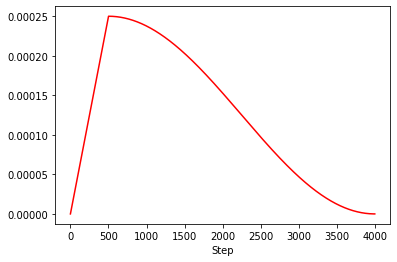

In [71]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [72]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1240064     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            16768       bert[0][0]                 

저는 학습이 좀 더 오래 걸려도 괜찮을 것 같았지만 지시한 대로 약 100만 개의 파라미터를 가지는 mini BERT 모델이 완성됐습니다.

In [73]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


`train_step`은 배치 사이즈에 따라 20000이 되겠고, `warmup_step`은 `train_step`의 10분의 1인 2000이 되겠습니다.

In [74]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
2000/2000 [==============================] - 109s 54ms/step - loss: 21.9494 - nsp_loss: 0.6760 - mlm_loss: 21.2733 - nsp_acc: 0.5455 - mlm_lm_acc: 0.0593

Epoch 00001: mlm_lm_acc improved from -inf to 0.05925, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 107s 53ms/step - loss: 19.7912 - nsp_loss: 0.6408 - mlm_loss: 19.1504 - nsp_acc: 0.6020 - mlm_lm_acc: 0.1106

Epoch 00002: mlm_lm_acc improved from 0.05925 to 0.11062, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 107s 53ms/step - loss: 19.0845 - nsp_loss: 0.6307 - mlm_loss: 18.4539 - nsp_acc: 0.6197 - mlm_lm_acc: 0.1239

Epoch 00003: mlm_lm_acc improved from 0.11062 to 0.12385, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 107s 53ms/step - loss: 18.7188 - nsp_loss: 0.6250 - mlm_los

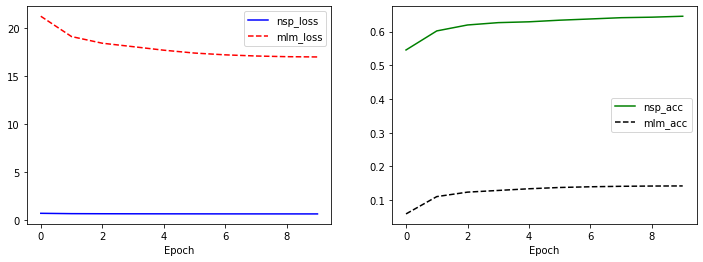

In [75]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

10 Epochs를 학습한 결과 전체 loss가 21.9에서 17.6으로 떨어지고, MLM학습과 NSP학습의 최종 정확도는 각 14%와 64%를 기록했습니다.

- - -
## 마무리하며

### *컨셉*

예제의 코드를 심도있게 보다보니 어디는 더 간단하게 수정할 수 있을 것 같고, 어디는 오류나 모순이 존재하고 하는 것들이 보이기 시작하면서

프로젝트를 시작할 때 *'내가 코드를 이해한 만큼 코드를 수정하기 위해 코드골프를 해보자'* 는 컨셉으로 임했습니다.

### *느낀점*

평소에도 코드골프를 하면 프로그램의 실행이 빨라질까? 하는 호기심을 가지고 있었습니다.

그것을 이번 기회에 확인해볼 수 있었는데, 결과는 살짝 예상은 했지만 별 차이 없었다입니다.

오히려 코드골프를 하기 위한 노력과 고뇌의 시간을 대가로 보면 코드골프는 아무런 의미가 없었던겁니다.

그러다보니 처음에는 코드의 줄 수를 줄이는 것이 컨셉이였지만,

의미가 없다는 걸 깨달으니 점점 코드를 줄인다기보단 코드의 의미가 더 직관적으로 다가오긴 개뿔 이게 뭐죠?

함수의 실행 속도가 빨라지는 것은 코드의 줄이 짧아지는 것과 별개의 일입니다.

### *아쉬운점*

keras에서 BERT를 사용한 예시 코드를 살펴본 적이 있는데, 그 때 BERT를 사용하는 전체적인 흐름은

1. BERT의 토크나이저를 불러와서 토큰화를 한다.
2. BERT에 토큰화한 데이터셋을 넣고 3개의 속성을 추출한다 (Token Emb, Segment Emb, Position Emb)
3. BERT에 추출한 3개의 속성을 넣고 학습을 하면 나오는 임베딩을 얻고 다운스트림에 사용할 수 있도록 이후 레이어를 추가한다.

였습니다.

과정과 원리를 알면 그 부분까지 구현할 수 있을까 싶었는데 모델을 설계하는 부분은 메서드들이 너무 많아서 눈에 잘 안들어온다는 문제가 있었습니다.